# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "S7-dim.ipynb"

    print('Done')

Done


# Part 1

functions that plot each panel.


---

monkey population CCA plot

In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [3]:
@utility.report
def plot_monkey_cca_dim(ax, full_list_MCx, allDFs_MCx):
    dim_range = range(2,20)

    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
        CCs= []
        for sessionData1, sessionData2 in zip(AllData1, AllData2):
            data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
            data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
            CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs [:,i]=CCs 

    # plotting
    x_ = list(dim_range)
    utility.shaded_errorbar(ax, x_, allCCs.T, color=params.colors.MonkeyPts, marker = 'o', label='Monkeys')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs


In [11]:
@utility.report
def plot_monkey_cca_dim_prep(ax, full_list_MCx, allDFs_MCx):
    dim_range = range(2,20)

    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            if 'J' in animal1 or 'J' in animal2: continue
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        AllData2 = dt.get_data_array(side2df, monkey_defs.prep_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
        CCs= []
        for sessionData1, sessionData2 in zip(AllData1, AllData2):
            data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
            data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
            CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs [:,i]=CCs 

    # plotting
    x_ = list(dim_range)
    utility.shaded_errorbar(ax, x_, allCCs.T, color=params.colors.MonkeyPts, marker = 'o', label='Monkeys')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs


Executed: `get_full_monkey_data` in 30.8s
Executed: `plot_monkey_cca_dim` in 921.9s


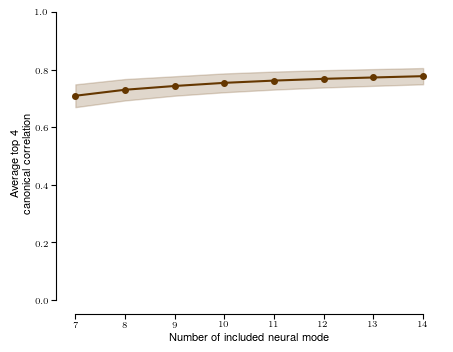

In [4]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])

    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca_dim(ax, full_list_MCx, allDFs_MCx)
    
    plt.show()

---

Mouse CCA plot

In [12]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [4]:
@utility.report
def plot_mouse_cca_dim(ax, allDFs_M1, area = 'M1'):
    dim_range = range(2,20)

    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]

    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=area, model=n_comp)
        AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=area, model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape), axis=0)
        CCs=[]
        for sessionData1,sessionData2 in zip(AllData1, AllData2):
                data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
                data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
                CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs[:,i] = CCs


    #====================================PLOTTING
    
    x_ = list(dim_range)
    c = params.colors.MouseM1 if 'M' in area else params.colors.MouseStr
    utility.shaded_errorbar(ax, x_, allCCs.T, color=c, marker = 'o', label=f'Mouse {area}')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs

@utility.report
def plot_mouse_cca_dim_prep(ax, allDFs_M1, area = 'M1'):
    dim_range = range(2,20)

    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]

    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=area, model=n_comp)
        AllData2 = dt.get_data_array(side2df, defs.prep_epoch, area=area, model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape), axis=0)
        CCs=[]
        for sessionData1,sessionData2 in zip(AllData1, AllData2):
                data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
                data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
                CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs[:,i] = CCs


    #====================================PLOTTING
    
    x_ = list(dim_range)
    c = params.colors.MouseM1 if 'M' in area else params.colors.MouseStr
    utility.shaded_errorbar(ax, x_, allCCs.T, color=c, marker = 'o', label=f'Mouse {area}')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs



Executed: `get_full_mouse_data` in 1.0s
Executed: `plot_mouse_cca_dim` in 23.8s


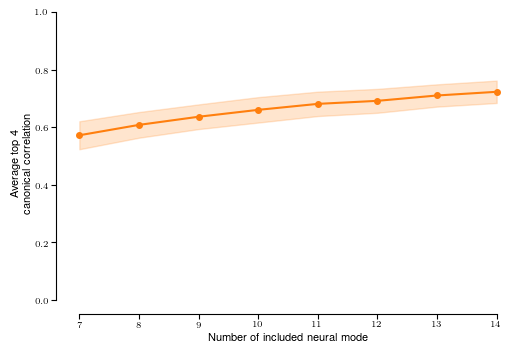

In [7]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=1, wspace=0)

    ax = fig.add_subplot(gs[0])

    allDFs_M1, allDFs_Str = get_full_mouse_data()
    
    plot_mouse_cca_dim(ax, allDFs_Str, 'Str')
    
    plt.show()

# Part 2
Plot figure

Executed: `get_full_monkey_data` in 14.3s
Executed: `plot_monkey_cca_dim` in 651.1s
Executed: `get_full_mouse_data` in 0.7s
Executed: `plot_mouse_cca_dim` in 16.4s
Executed: `plot_mouse_cca_dim` in 16.5s
Executed: `get_full_monkey_data` in 16.3s
Executed: `plot_monkey_cca_dim_prep` in 431.9s
Executed: `get_full_mouse_data` in 0.8s
Executed: `plot_mouse_cca_dim_prep` in 20.7s
Executed: `plot_mouse_cca_dim_prep` in 19.7s


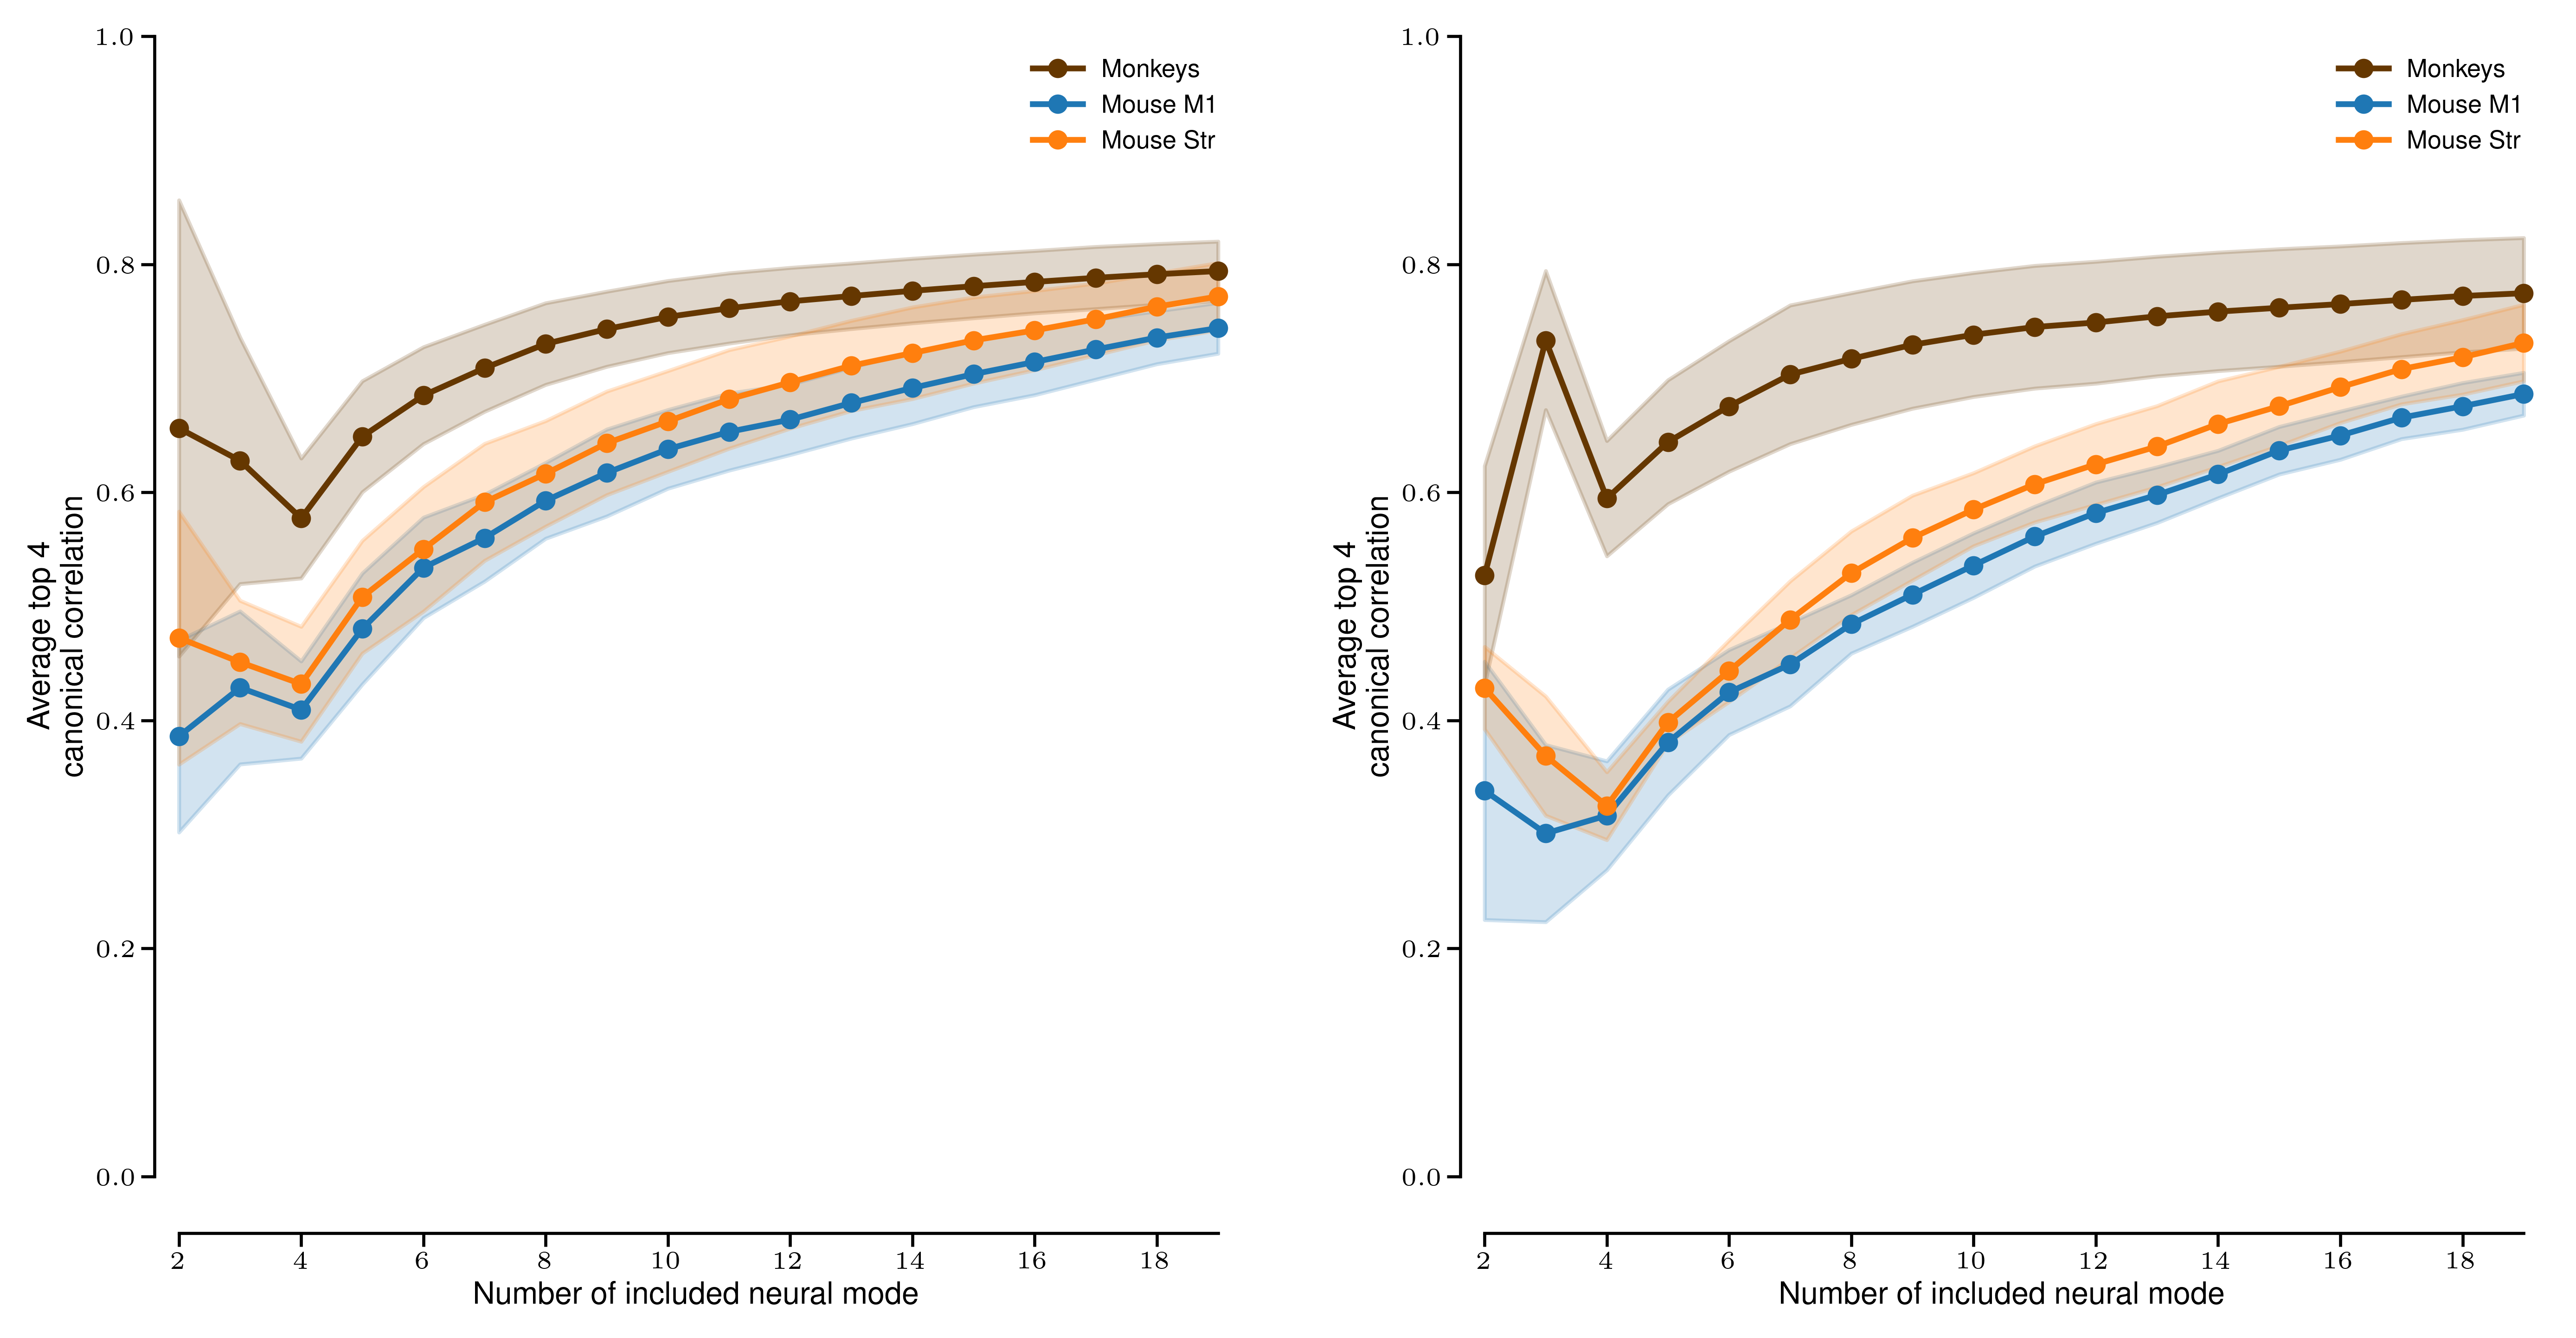

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= params.panels.cca
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: Monkey CCA
    gs1 =utility.add_gridspec_abs(fig, nrows=1, ncols=2,
                            bottom=0, left=0,
                            right=1,  top=1, 
                            width = params.MedFig[0] * 2,
                            height = params.MedFig[1])

    ax1 = fig.add_subplot(gs1[0])
    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca_dim(ax1, full_list_MCx, allDFs_MCx)

    
    
    ##########################################
    # 2: MOUSE CCA M1 and Str

    
    allDFs_M1, allDFs_Str = get_full_mouse_data()


    plot_mouse_cca_dim(ax1, allDFs_M1)
    plot_mouse_cca_dim(ax1, allDFs_Str, 'Str')

    ax1.legend()

    ##########################################
    # 1: Monkey CCA prep
    ax2 = fig.add_subplot(gs1[1])
    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca_dim_prep(ax2, full_list_MCx, allDFs_MCx)

    
    
    ##########################################
    # 2: MOUSE CCA M1 and Str prep

    
    allDFs_M1, allDFs_Str = get_full_mouse_data()


    plot_mouse_cca_dim_prep(ax2, allDFs_M1)
    plot_mouse_cca_dim_prep(ax2, allDFs_Str, 'Str')

    ax2.legend()
    
    
#     fig.align_ylabels([ax1,ax4])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # AXES=(ax1,ax2,ax3,ax4,ax5,ax6)
    # OFFX=np.array([.02]*len(AXES))
    # OFFY=np.array([.03]*len(AXES))
    # OFFX[[-1]]=0.12
    # OFFX[[1]]=0.06
    
    # params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS7-dim.pdf', format='pdf', bbox_inches='tight')